In [26]:
import os
import numpy as np
import time
import copy
import sys
import re

import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_stm_utilities as csu

In [2]:
#folder = "/home/kristjan/local_work/morbs_test/cp2k_basis_test/"
#file_basis_set = folder + "BASIS_SET"
#file_xyz = folder + "h2.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"

folder = "/home/kristjan/local_work/morbs_test/cnt120-L2-spin-pol/"
file_basis_set = folder + "BR"
file_xyz = folder + "cnt120-L2-ideal-spin-ends.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"

#folder = "/home/kristjan/local_work/morbs_test/c2h2/"
#file_basis_set = folder + "BR"
#file_xyz = folder + "p.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "out"

In [3]:
emin = -0.5
emax =  0.5

In [4]:
time1 = time.time()
elem_basis_names, cell = csu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = csu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

time1 = time.time()
ase_atoms = csu.read_xyz(file_xyz)
csu.center_atoms_to_cell(ase_atoms.positions, cell/ang_2_bohr)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
morb_composition, morb_energies, morb_occs, homo_inds, ref_en = csu.load_restart_wfn_file(file_restart, emin, emax)
print("Found %d orbitals" % len(morb_energies[0]))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.003
Read basis sets: 0.005
Read xyz: 0.007
S0 nmo: 1588, [eV] H-1 -3.40004189 Homo -3.40003793 H+1 -2.72076802
S1 nmo: 1588, [eV] H-1 -3.40006011 Homo -3.40005569 H+1 -2.72077173
Found 5 orbitals
Read restart: 0.641


In [24]:
homo_inds

[[4, 4], [588, 588], [593, 593]]

In [25]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.16 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# !!! NB: Redefine cell such that step stays the same (and a factor of lattice param)
#cell = cell_n*step

#csu.center_atoms_to_cell(at_positions, cell)

In [26]:
# define evaluation region:

x_eval_region = None
y_eval_region = None
z_eval_region = None

eval_regions = [x_eval_region, y_eval_region, z_eval_region]

origin = np.zeros(3)
new_cell = np.copy(cell)

for i, e_reg in enumerate(eval_regions):
    if e_reg is None:
        origin[i] = 0.0
        new_cell[i] = cell[i]
    else:
        origin[i] = e_reg[0]
        new_cell[i] = e_reg[1] - e_reg[0]


In [27]:
ase_atoms

Atoms(symbols='C288H24', pbc=False, cell=[26.42, 9.31427189299, 9.31427189299])

In [64]:
cell

array([ 79.36849727,  47.24315314,  47.24315314])

In [28]:
morb_grids_new = csu.calc_morbs_in_region(cell, cell_n,
                                         ase_atoms,
                                         basis_sets, morb_composition,
                                         x_eval_region = x_eval_region,
                                         y_eval_region = y_eval_region,
                                         z_eval_region = z_eval_region,
                                         eval_cutoff = 12.0
                                        )

Global cell:  [262 156 156]
Eval cell:  [262 156 156]
local cell:  [75 75 75]
---- Setup: 0.0264
---- Radial calc time : 80.783451
---- Spherical calc time : 7.264869
---- Loc -> loc_morb time : 37.975734
---- loc_morb -> glob time : 7.253676
---- Total time: 136.1677


In [31]:
morb_grids_new[0].shape

(5, 262, 156, 156)

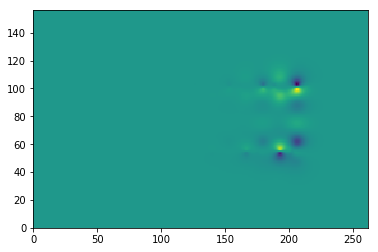

In [41]:
plt.pcolormesh(morb_grids_new[0][4][:, :, 60].T)
plt.show()

In [42]:
save_morb = morb_grids_new[1][homo_inds[0][1]]

csu.write_cube_file("/home/kristjan/local_work/morbs_test/test.cube",
                   ase_atoms, new_cell, save_morb.shape, save_morb, origin = origin)

In [43]:
# check for normalization
dv = cell/cell_n
vol_elem = dv[0]*dv[1]*dv[2]
np.sum(morb_grids_new[0][0]**2)*vol_elem

0.9999962288429185